# Preparation

In [2]:
# Packages
import cv2
import urllib.request as urlreq
import os
import matplotlib.pyplot as plt
#from pylab import rcParams
import numpy as np
import math
import dlib
import joblib
from scipy.spatial import ConvexHull
from skimage.morphology.convex_hull import grid_points_in_poly
from skimage.feature import hog
import warnings
warnings.filterwarnings('ignore')

In [3]:
pwd

'/Users/kristshingjergji/Documents/PhD/Experiment_1'

In [4]:
predictor=  dlib.shape_predictor("/Users/kristshingjergji/Documents/PhD/Experiment_1/models/shape_predictor_68_face_landmarks.dat")
pca_model = joblib.load("models/hog_pca_all_emotio.joblib")
classifier = joblib.load("models/svm_568.joblib")
scaler = joblib.load("models/hog_scalar_aus.joblib")

In [5]:
pwd

'/Users/kristshingjergji/Documents/PhD/Experiment_1'

In [9]:
# Inputs 
file_prefix = "paper_data" # only change this line
hogs_filename = file_prefix + "_hogs.txt"
landmarks_filename = file_prefix + "_landmarks.txt"
full_filename = file_prefix + "_big.png"
cropped_filename = file_prefix + "_small.png"

image = cv2.imread('kristi.jpg')

predictor=dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")
pca_model = joblib.load("models/hog_pca_all_emotio.joblib")
classifier = joblib.load("models/svm_568.joblib")
scaler = joblib.load("models/hog_scalar_aus.joblib")

In [10]:
# Functions
def shape_to_np(shape, dtype="int"):
    coords = np.zeros((68, 2), dtype=dtype)
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    return coords

def bounding_box_naive(points):
    """returns a list containing the bottom left and the top right 
    points in the sequence
    """
    top_left_x = min(point[0] for point in points)
    top_left_y = min(point[1] for point in points)
    bot_right_x = max(point[0] for point in points)
    bot_right_y = max(point[1] for point in points)

    return [(top_left_x, top_left_y), (bot_right_x, bot_right_y)]

def getNewCoords(point_x,point_y,upperleftX, upperleftY, lowerrightX, lowerRightY, image_width,image_height):
    """returns the new coordinates of a point (point_x,point_y), in a cropped bounding box (upperleftX, upperleftY, lowerrightX, lowerRightY)
      and rescaled (image_width,image_height) image 
    """

    sizeX = lowerrightX - upperleftX
    sizeY =  lowerRightY - upperleftY
    centerX = (lowerrightX + upperleftX)/2
    centerY = (lowerRightY + upperleftY)/2

    offsetX = (centerX-sizeX/2)*image_width/sizeX
    offsetY = (centerY-sizeY/2)*image_height/sizeY

    point_x = point_x * image_width/sizeX - offsetX 
    point_y = point_y * image_height/sizeY - offsetY
    return (point_x,point_y)

def rotate(img, angle, landmarks):
    width, height = img.shape[:2]
    rotation = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
    rotated_img = cv2.warpAffine(img, rotation, (width, height))

    rotated_landmarks = np.asarray([np.dot(rotation, landmark.T) for landmark in landmarks])
    return rotated_img, rotated_landmarks

# Process starts here 

## Get landmarks 

## Offline

118 290 504 675


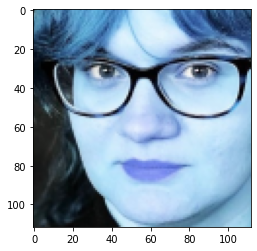

In [11]:
# Detect face and landmarks with dlib
detector = dlib.get_frontal_face_detector() 
detect=detector(image,1)
shape=predictor(image,detect[0]) #the landmarks in another form
shape = shape_to_np(shape)
rects = detector(image, 1) # the coordinates of the rectangles of the face

# Get the bounding box in the face and plot it
for k, d in enumerate(rects):
    x = d.left()
    y = d.top()
    w = d.right()
    h = d.bottom()
    print(x,y,w,h)
    
for ix in range(60,0,-1):
    #print(ix)
    if x-ix > 0:
        break
for iy in range(60,0,-1):
    #print(iy)
    if y-iy > 0:
        break
for iw in range(60,0,-1):
    #print(iw)
    if w+iw < image.shape[1]:
        break
for ih in range(60,0,-1):
    #print(ih)
    if h-ih < image.shape[1]:
        break
        
offine_cropped_image = image[ y:h, x:w]
offline_resized_cropped= cv2.resize(offine_cropped_image, (112,112), interpolation = cv2.INTER_AREA)
plt.imshow(offline_resized_cropped)

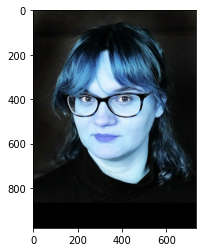

In [12]:
plt.imshow(image)

In [13]:
# Cropped and resized landmarks landmarks 
shape_cropped_resized = []
for landmark in range(len(shape)):
    x_old = shape[landmark][0]
    y_old = shape[landmark][1]
    (x_new, y_new) = getNewCoords(x_old, y_old, x, y, w, h, 112, 112 )
    shape_cropped_resized.append((x_new, y_new))

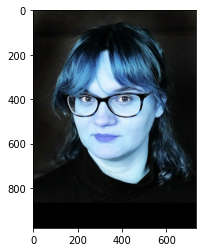

In [14]:
plt.imshow(image)

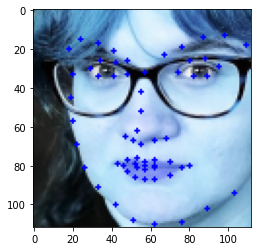

In [15]:
resized_cropped_template = offline_resized_cropped.copy()
for (x, y) in shape_cropped_resized:
    cv2.circle(resized_cropped_template, (int(x), int(y)), 1, (0, 0, 255), -1)
plt.imshow(resized_cropped_template)

In [19]:
left = [36, 37, 38, 39, 40, 41] # keypoint indices for left eye
right = [42, 43, 44, 45, 46, 47] # keypoint indices for right eye
points_left = [shape_cropped_resized[i] for i in left]
points_right = [shape_cropped_resized[i] for i in right]

eye_left = bounding_box_naive(points_left)
eye_right = bounding_box_naive(points_right)

# Get the eyes coordinates
ex1 = eye_left[0][0]
ey1 = eye_left[0][1]
ew1 = eye_left[1][0] - ex1
ed1 = eye_left[0][1] - ey1

ex2 = eye_right[0][0]
ey2 = eye_right[0][1]
ew2 = eye_right[1][0] - ex2
ed2 = eye_right[0][1] - ey2

left_eye = (ex1,ey1,ew1,ed1)
right_eye = (ex2,ey2,ew2,ed2)

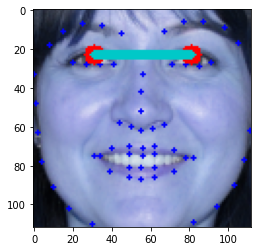

In [20]:
# Align
left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
left_eye_x = left_eye_center[0] 
left_eye_y = left_eye_center[1]
 
right_eye_center = (int(right_eye[0] + (right_eye[2]/2)), int(right_eye[1] + (right_eye[3]/2)))
right_eye_x = right_eye_center[0]
right_eye_y = right_eye_center[1]
 
cv2.circle(resized_cropped_template, left_eye_center, 5, (255, 0, 0) , -1)
cv2.circle(resized_cropped_template, right_eye_center, 5, (255, 0, 0) , -1)
cv2.line(resized_cropped_template,right_eye_center, left_eye_center,(0,200,200),3)
plt.imshow(resized_cropped_template)

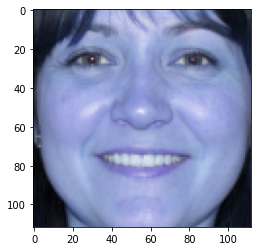

In [21]:
delta_x = right_eye_x - left_eye_x
delta_y = right_eye_y - left_eye_y
angle=np.arctan(delta_y/delta_x)
angle = (angle * 180) / np.pi

# Width and height of the image
h, w = offline_resized_cropped.shape[:2]
# Calculating a center point of the image
# Integer division "//"" ensures that we receive whole numbers
center = (w // 2, h // 2)
# Defining a matrix M and calling
# cv2.getRotationMatrix2D method
M = cv2.getRotationMatrix2D(center, (angle), 1.0)
# Applying the rotation to our image using the
# cv2.warpAffine method
rotated = cv2.warpAffine(offline_resized_cropped, M, (w, h))
plt.imshow(rotated)

In [22]:
shape_cropped_resized = np.asarray(shape_cropped_resized)

In [23]:
shape_cropped_resized3d = shape_cropped_resized.copy()
ones = np.ones((68,1), dtype=int)
shape_cropped_resized3d = np.concatenate((shape_cropped_resized3d, ones), axis=1)

In [24]:
rotated_landmarks = np.asarray([np.dot(M, landmark.T) for landmark in shape_cropped_resized3d])

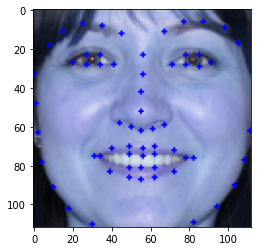

In [25]:
rotated_template = rotated.copy()
for (x, y) in rotated_landmarks:
    cv2.circle(rotated_template, (int(x), int(y)), 1, (0, 0, 255), -1)
plt.imshow(rotated_template)

In [26]:
hull = ConvexHull(rotated_landmarks)
mask = grid_points_in_poly(shape=np.array(rotated).shape, 
                verts= list(zip(rotated_landmarks[hull.vertices][:,1], rotated_landmarks[hull.vertices][:,0]))) # for some reason verts need to be flipped
                               

In [33]:
type(rotated_landmarks)

numpy.ndarray

In [36]:
type(rotated_landmarks[0])

numpy.ndarray

In [38]:
rotated_landmarks[0][0]

0.20180180180179974

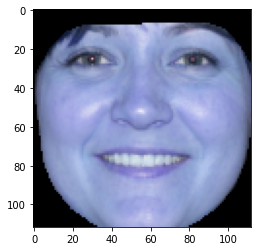

In [27]:
rotated[~mask] = 0
plt.imshow(rotated)

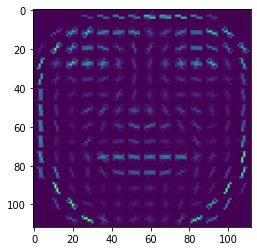

In [28]:
offline_hogs, hogs_im = hog(rotated, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
plt.imshow(hogs_im)

In [29]:
scaled_hogs = scaler.fit_transform(offline_hogs.reshape(-1,1))[0:5408].reshape(1,-1)
pca_transformed_frame = pca_model.transform(scaled_hogs)
feature_cbd = np.concatenate((pca_transformed_frame, rotated_landmarks.reshape(1,-1)), 1)

In [30]:
offline_pred_aus = []
for keys in classifier:
    au_pred = classifier[keys].predict(feature_cbd)
    offline_pred_aus.append(au_pred)

In [31]:
au_array = [1,2,4,5,6,7,9,10,11,12,14,15,17,20,23,24,25,26,28,43]
for i in range(len(offline_pred_aus)):
    if offline_pred_aus[i] ==1:
        print(au_array[i])

6
7
10
11
12
15
17
20
25
26


## Combined 

In [242]:
cropped_filename

'paper_data_small.png'

In [243]:
image_combined = cv2.imread(cropped_filename)

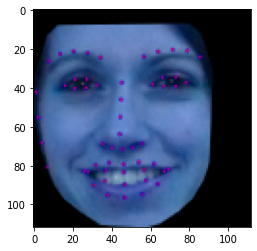

In [244]:
plt.imshow(image_combined)

In [245]:
offine_hogs_online, offine_hogs_online_im = hog(image_combined, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)

In [246]:
text_file = open(landmarks_filename, "r")
lines = text_file.readlines()
my_string = lines[0]
my_list = my_string.split(",")
my_float= [float(x) for x in my_list]
online_landmarks = np.reshape(my_float, (68, 2))

In [247]:
offine_hogs_online_scaled = scaler.fit_transform(offine_hogs_online.reshape(-1,1))[0:5408].reshape(1,-1)

pca_transformed_frame = pca_model.transform(offine_hogs_online_scaled)
feature_cbd = np.concatenate((pca_transformed_frame, online_landmarks.reshape(1,-1)), 1)

combined_pred_aus = []
for keys in classifier:
    au_pred = classifier[keys].predict(feature_cbd)
    combined_pred_aus.append(au_pred)

In [248]:
au_array = [1,2,4,5,6,7,9,10,11,12,14,15,17,20,23,24,25,26,28,43]
for i in range(len(combined_pred_aus)):
    if combined_pred_aus[i] ==1:
        print (au_array[i])

6
7
11
12
14
20
25


## Online 

In [250]:
text_file_landmarks = open(landmarks_filename, "r")
lines_landmarks = text_file_landmarks.readlines()
string_landmarks = lines_landmarks[0]
list_landmarks = string_landmarks.split(",")
online_landmarks= [float(x) for x in list_landmarks]
online_landmarks = np.reshape(online_landmarks, (68, 2))

In [251]:
text_file_hogs = open(hogs_filename, "r")
lines_hogs = text_file_hogs.readlines()
string_hogs = lines_hogs[0]
list_hogs = string_hogs.split(",")
online_hogs = [float(x) for x in list_hogs]
online_hogs = np.reshape(online_hogs, (5408,))

In [252]:
online_hogs_scaled = scaler.fit_transform(online_hogs.reshape(-1,1))[0:5408].reshape(1,-1)

pca_transformed_frame = pca_model.transform(online_hogs_scaled)
feature_cbd = np.concatenate((pca_transformed_frame, online_landmarks.reshape(1,-1)), 1)

online_pred_aus = []
for keys in classifier:
    au_pred = classifier[keys].predict(feature_cbd)
    online_pred_aus.append(au_pred)

In [253]:
au_array = [1,2,4,5,6,7,9,10,11,12,14,15,17,20,23,24,25,26,28,43]
for i in range(len(online_pred_aus)):
    if online_pred_aus[i] ==1:
        print(au_array[i])

6
7
11
12
14
20
25


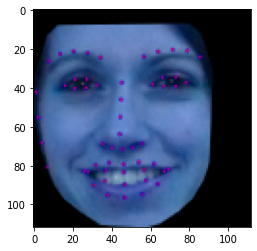

In [254]:
online_small = cv2.imread(cropped_filename)
plt.imshow(online_small)

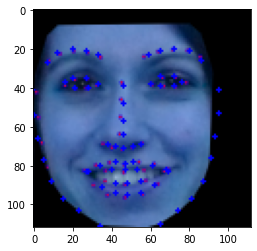

In [255]:
online_small_template = online_small.copy()
for (x, y) in online_landmarks:
    cv2.circle(online_small_template, (int(x), int(y)), 1, (0, 0, 255), -1)
plt.imshow(online_small_template)

## Results 

In [256]:
print('----------')
print('Predictions online')
for i in range(len(online_pred_aus)):
    if online_pred_aus[i] ==1:
        print(au_array[i])
print('----------')
print('Predictions offline')
for i in range(len(offline_pred_aus)):
    if offline_pred_aus[i] ==1:
        print(au_array[i])

print('----------')
print('Predictions combined')
for i in range(len(combined_pred_aus)):
    if combined_pred_aus[i] ==1:
        print(au_array[i])

----------
Predictions online
6
7
11
12
14
20
25
----------
Predictions offline
1
6
7
10
11
12
25
----------
Predictions combined
6
7
11
12
14
20
25
